# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = [X_train.shape[1], X_train.shape[2]]

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


In [3]:
import os
import csv
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
# Allow image embeding in notebook
%matplotlib inline

print('All modules imported.')

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False


All modules imported.


['ClassId', 'SignName']
['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']
['5', 'Speed limit (80km/h)']
['6', 'End of speed limit (80km/h)']
['7', 'Speed limit (100km/h)']
['8', 'Speed limit (120km/h)']
['9', 'No passing']
['10', 'No passing for vechiles over 3.5 metric tons']
['11', 'Right-of-way at the next intersection']
['12', 'Priority road']
['13', 'Yield']
['14', 'Stop']
['15', 'No vechiles']
['16', 'Vechiles over 3.5 metric tons prohibited']
['17', 'No entry']
['18', 'General caution']
['19', 'Dangerous curve to the left']
['20', 'Dangerous curve to the right']
['21', 'Double curve']
['22', 'Bumpy road']
['23', 'Slippery road']
['24', 'Road narrows on the right']
['25', 'Road work']
['26', 'Traffic signals']
['27', 'Pedestrians']
['28', 'Children crossing']
['29', 'Bicycles crossing']
['30', 'Beware of ice/snow']
['31', 'Wild animals crossing']
['32', 'End of all speed and passin

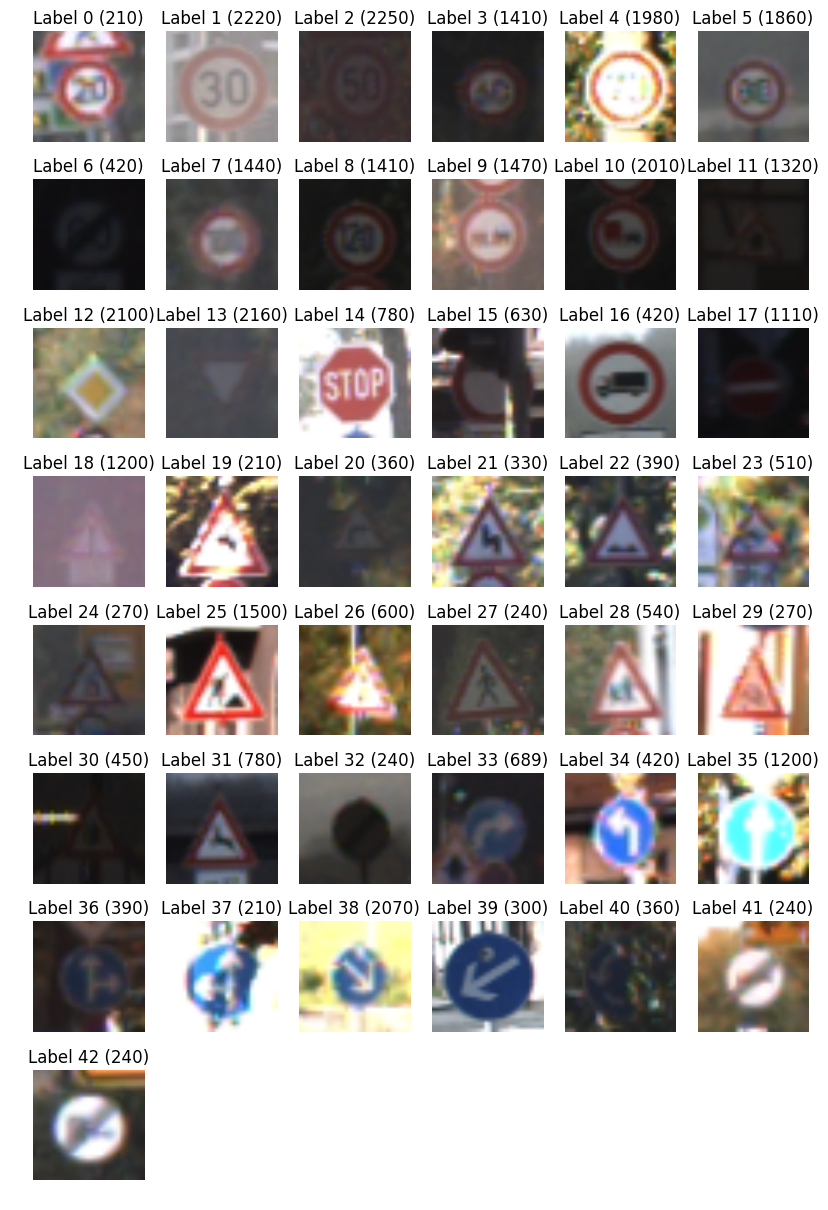

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
with open( './signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        print(line)
f.close() 

print("Top 5 labels in training dataset = ", Counter(y_train).most_common(5))
print("Top 5 labels in testing dataset = " , Counter(y_test).most_common(5))

index = 1
plt.figure(figsize=(10, 15))
for label in range(n_classes):
    image = X_train[y_train.tolist().index(label)]
    plt.subplot(8, 6, index)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(label, y_train.tolist().count(label)))
    index += 1
    plt.imshow(image)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Preprocess Done!


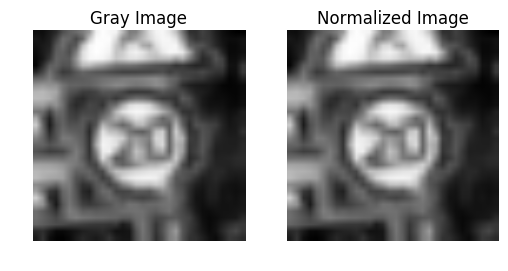

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def rgb2gray(X_rgb, n):
    """
    :return: gray image
    """
    X_gray = np.zeros(X_rgb.shape[0:3])
    for i in range(n):
        X_gray[i] = cv2.cvtColor(X_rgb[i], cv2.COLOR_RGB2GRAY)
    return X_gray
    
    
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

X_train_gray = rgb2gray(X_train, n_train)
X_test_gray = rgb2gray(X_test, n_test)

if not is_features_normal:
    train_features  = normalize_grayscale(X_train_gray)
    test_features  = normalize_grayscale(X_test_gray)
    is_features_normal = True

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Gray Image")
plt.imshow(X_train_gray[0], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Normalized Image")
plt.imshow(train_features[0], cmap='Greys_r')

print('Preprocess Done!')


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
1. RGB image to gray image.
2. Normailize these gray images

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    train_labels = encoder.transform(y_train)
    test_labels = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [7]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.
(37248, 43)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [8]:
# Save the data for easy access
pickle_file = 'TrafficSign.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('TrafficSign.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.
(37248, 43)


In [30]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = './TrafficSign.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')
print('Training set', train_features.shape, train_labels.shape)
print('Validation set', valid_features.shape, valid_labels.shape)
print('Test set', test_features.shape, test_labels.shape)

Data and modules loaded.
Training set (37248, 32, 32) (37248, 43)
Validation set (1961, 32, 32) (1961, 43)
Test set (12630, 32, 32) (12630, 43)


In [46]:
def reformat(dataset):
  dataset = dataset.reshape((-1, train_features.shape[1], train_features.shape[2], 1)).astype(np.float32)
  return dataset
train_features = reformat(train_features)
valid_features = reformat(valid_features)
test_features = reformat(test_features)

print('Training set', train_features.shape, train_labels.shape)
print('Validation set', valid_features.shape, valid_labels.shape)
print('Test set', test_features.shape, test_labels.shape)

Training set (37248, 32, 32, 1) (37248, 43)
Validation set (1961, 32, 32, 1) (1961, 43)
Test set (12630, 32, 32, 1) (12630, 43)


In [47]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [57]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

image_size = train_features.shape[1]
num_labels = train_labels.shape[1]
num_channels = 1 # grayscale

batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_features)
  tf_test_dataset = tf.constant(test_features)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Initialized
Minibatch loss at step 0: 4.059280
Minibatch accuracy: 9.4%
Validation accuracy: 0.7%
Minibatch loss at step 50: 3.446237
Minibatch accuracy: 6.2%
Validation accuracy: 5.3%
Minibatch loss at step 100: 3.378085
Minibatch accuracy: 0.0%
Validation accuracy: 6.2%
Minibatch loss at step 150: 3.349884
Minibatch accuracy: 12.5%
Validation accuracy: 5.7%
Minibatch loss at step 200: 3.109105
Minibatch accuracy: 12.5%
Validation accuracy: 8.8%
Minibatch loss at step 250: 3.712033
Minibatch accuracy: 3.1%
Validation accuracy: 11.6%
Minibatch loss at step 300: 3.389863
Minibatch accuracy: 3.1%
Validation accuracy: 14.9%
Minibatch loss at step 350: 3.161918
Minibatch accuracy: 12.5%
Validation accuracy: 16.5%
Minibatch loss at step 400: 2.809610
Minibatch accuracy: 31.2%
Validation accuracy: 26.9%
Minibatch loss at step 450: 2.384296
Minibatch accuracy: 43.8%
Validation accuracy: 30.8%
Minibatch loss at step 500: 2.047924
Minibatch accuracy: 40.6%
Validation accuracy: 34.3%
Minibatch l

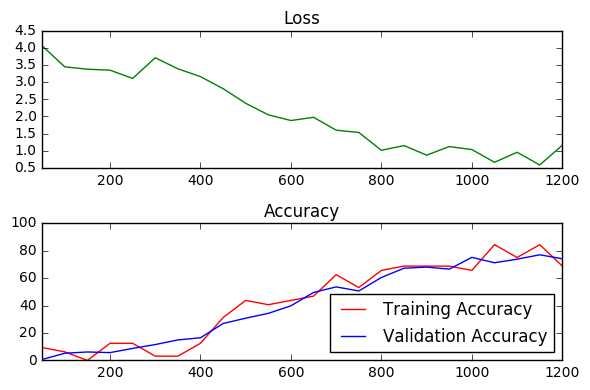

In [61]:
### Train your model here.
### Feel free to use as many code cells as needed.

# ToDo: Find the best parameters for each configuration
num_steps = train_labels.shape[0] // batch_size

log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)   
    batch_data = train_features[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    # Log every 50 batches
    if (step % log_batch_step == 0):
      training_accuracy = accuracy(predictions, batch_labels)
      validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      
      # Log batches
      previous_batch = batches[-1] if batches else 0
      batches.append(log_batch_step + previous_batch)
      loss_batch.append(l)
      train_acc_batch.append(training_accuracy)
      valid_acc_batch.append(validation_accuracy)
      
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % training_accuracy)
      print('Validation accuracy: %.1f%%' % validation_accuracy)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 100.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [62]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.